In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold


from matplotlib import pyplot
import itertools

%matplotlib inline

import random

random.seed(42)

In [ ]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)

    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
def print_4_metrics(target_test, predicted):
  print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
  print("%-12s %f" % ('Precision:', metrics.precision_score(target_test, predicted,labels=None, pos_label=1, average='binary', sample_weight=None)))
  print("%-12s %f" % ('Recall:', metrics.recall_score(target_test, predicted,labels=None, pos_label=1, average='binary', sample_weight=None)))
  print("%-12s %f" % ('F1 Score:', metrics.f1_score(target_test, predicted,labels=None, pos_label=1, average='binary', sample_weight=None)))


**Data Preprocessing**

In [ ]:
url='https://drive.google.com/file/d/1_U-J7E30JmE8Q7KuMT723dI7QxJAxhAB/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

df = pd.read_csv(url)

In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Deleting ID because this column is not needed in the model

In [ ]:
data = df.drop('id', axis = 1)

In [ ]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Filling in Null Values

Median filled into BMI (Median Imputation)

In [ ]:
median = data["bmi"].median()
data["bmi"].fillna(median, inplace=True)
null_rows = data[data.isnull().any(axis=1)]
null_rows

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


Replacing Null smoking values

In [ ]:
data["stroke"].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [ ]:
known_smoking = data[data["smoking_status"] != "Unknown"]

In [ ]:
balanced_data = known_smoking.sort_values('stroke', ascending=False).head(404)
balanced_data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
170,Male,64.0,0,0,Yes,Self-employed,Rural,111.98,28.1,formerly smoked,1
158,Female,71.0,0,0,Yes,Self-employed,Urban,195.71,34.1,formerly smoked,1
159,Female,81.0,1,0,Yes,Self-employed,Rural,74.02,25.0,never smoked,1
160,Female,76.0,0,0,Yes,Private,Urban,57.92,28.1,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
3387,Female,78.0,1,0,No,Self-employed,Rural,198.12,29.1,never smoked,0
3376,Female,75.0,0,0,Yes,Private,Rural,226.73,43.7,never smoked,0
3377,Female,51.0,0,0,Yes,Self-employed,Urban,89.74,28.4,never smoked,0
3378,Male,51.0,0,0,No,Self-employed,Rural,219.17,29.8,never smoked,0


In [ ]:
null_rows = balanced_data[balanced_data.isnull().any(axis=1)] #Used to check if any rows contain null data
null_rows

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


Preprocessing the Dataset

In [ ]:
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


# Categorical Features
categorical_features = ["gender", 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


le = preprocessing.LabelEncoder()
for c in categorical_features:
  le.fit(balanced_data[c])
  balanced_data[c]=le.transform(balanced_data[c])

# Numerical Features

scaler = StandardScaler()
scale_data = balanced_data[['age', 'avg_glucose_level', 'bmi']]
binary_data = balanced_data.drop(['age', 'avg_glucose_level', 'bmi'], axis=1)
scaled_data = scaler.fit_transform(scale_data)

df_scaled_data = pd.DataFrame(scaled_data, columns=scale_data.columns)
# Something is wrong here
binary_data = binary_data.reset_index()
all_data = pd.concat([df_scaled_data, binary_data], axis=1)


In [ ]:
all_data = all_data.drop(['index'], axis =1)

KeyError: ignored

In [ ]:
df_correlation = all_data.corr()
df_correlation['stroke'].sort_values(ascending=False)

stroke               1.000000
age                  0.539804
avg_glucose_level    0.225583
hypertension         0.215883
heart_disease        0.201229
ever_married         0.166375
bmi                  0.108830
work_type            0.073659
Residence_type       0.009909
gender               0.005010
smoking_status      -0.065240
Name: stroke, dtype: float64

In [ ]:
data_target = all_data["stroke"]
data_prepared = all_data.drop(['stroke'], axis=1)

In [ ]:
data_prepared

,age,avg_glucose_level,bmi,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status
0,0.476377,1.875785,1.130292,1,0,1,1,2,1,0
1,0.313508,-0.165599,-0.264198,1,0,0,1,3,0,0
2,0.693534,1.298929,0.720148,0,0,0,1,3,1,0
3,1.236429,-0.829561,-0.772776,0,1,0,1,3,0,1
4,0.964982,-1.111168,-0.264198,0,0,0,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...
399,1.073561,1.341083,-0.100140,0,1,0,0,3,0,1
400,0.910692,1.841503,2.295101,0,0,0,1,2,0,1
401,-0.392255,-0.554601,-0.214980,0,0,0,1,3,1,1
402,-0.392255,1.709270,0.014700,1,0,0,0,3,0,1


# **MODELS**

Train-Test Split

In [ ]:
train, test, target, target_test = train_test_split(data_prepared, data_target, test_size = 0.2, random_state = 0)

Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(penalty = 'l1', solver='liblinear', C = 0.15)

log_reg.fit(train, target)

log_predicted = log_reg.predict(test)
log_score = log_reg.predict_proba(test)[:,1]
print_4_metrics(target_test, log_predicted)

Accuracy:    0.728395
Precision:   0.765957
Recall:      0.765957
F1 Score:    0.765957


In [ ]:
C_values = []
C = 0.1
while C < 0.35:
  C_values.append(C)
  C += 0.05

for c in C_values:
  log_reg = LogisticRegression(penalty = 'l1', solver='liblinear', C = 0.15)

  log_reg.fit(train, target)

  log_predicted = log_reg.predict(test)
  print(f"C value: {c}")
  print(f"Accuracy: {metrics.accuracy_score(target_test,log_predicted)}", '\n')

C value: 0.1
Accuracy: 0.7283950617283951 

C value: 0.15000000000000002
Accuracy: 0.7283950617283951 

C value: 0.2
Accuracy: 0.7283950617283951 

C value: 0.25
Accuracy: 0.7283950617283951 

C value: 0.3
Accuracy: 0.7283950617283951 



In [ ]:
print_4_metrics(target_test, log_predicted)

Accuracy:    0.728395
Precision:   0.765957
Recall:      0.765957
F1 Score:    0.765957


Logistic Model Performance Results:

AUC of ROC:  0.7571964956195244


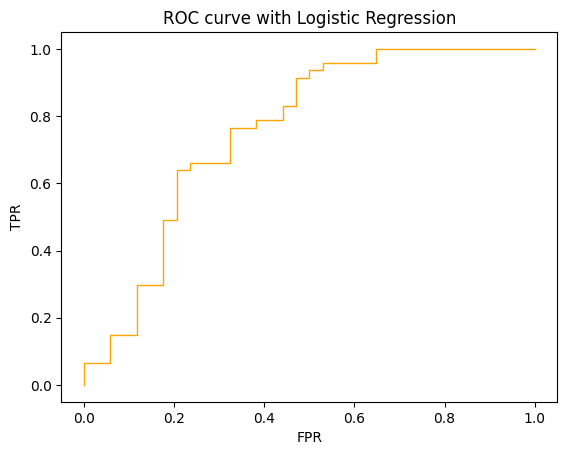

In [ ]:
# Plot ROC curve and report area under ROC
# use metrics.roc_curve(your y_test, predicted probabilities for y_test)

fpr_log_reg, tpr_log_reg, thresholds = metrics.roc_curve(target_test,log_score)
print("Logistic Model Performance Results:\n")
pyplot.figure(1)
pyplot.plot(fpr_log_reg, tpr_log_reg, color='orange', lw=1)
pyplot.title("ROC curve with Logistic Regression")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')

# report auc
# use metrics.auc(fpr, tpr)
aucroc = metrics.auc(fpr_log_reg, tpr_log_reg)
print('AUC of ROC: ', aucroc)


<class 'numpy.ndarray'>


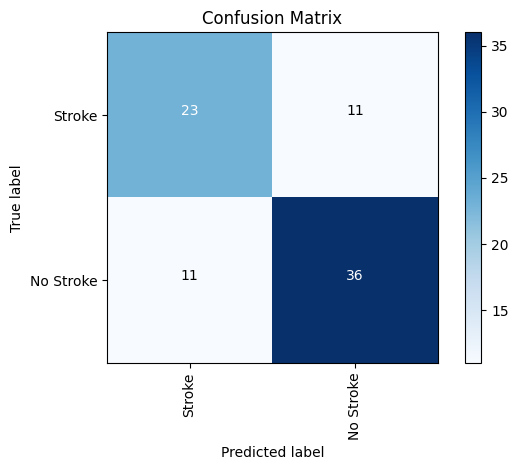

In [ ]:
from sklearn.metrics import confusion_matrix
print(type(log_predicted))
draw_confusion_matrix(target_test, log_predicted, ['Stroke', 'No Stroke'])

K-Nearest Neighbor

In [ ]:
for k in range(1,300):

    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(train, target)
    KNN_predicted = KNN.predict(test)

    print(f"K value: {k}")
    print(f"Accuracy: {metrics.accuracy_score(target_test,KNN_predicted)}", '\n')

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=81, algorithm='ball_tree', p=1)

KNN.fit(train, target)

KNN_predicted = KNN.predict(test)
KNN_score = KNN.predict_proba(test)[:,1]

Accuracy:    0.691358
Precision:   0.750000
Recall:      0.702128
F1 Score:    0.725275


In [ ]:
print_4_metrics(target_test, KNN_predicted)

Accuracy:    0.691358
Precision:   0.750000
Recall:      0.702128
F1 Score:    0.725275


KNN Model Performance Results:

AUC of ROC:  0.7346683354192741


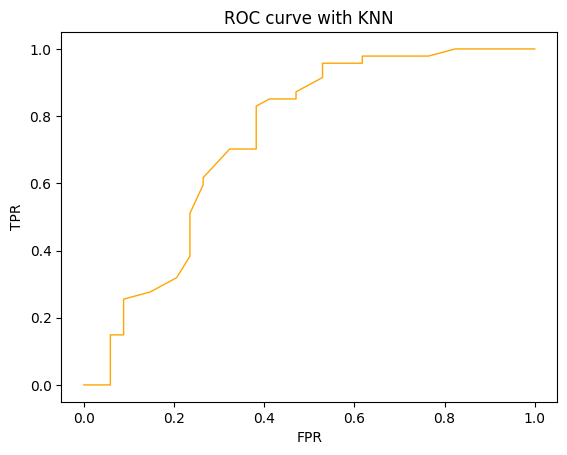

In [ ]:
# Plot ROC curve and report area under ROC
# use metrics.roc_curve(your y_test, predicted probabilities for y_test)

fpr_KNN, tpr_KNN, thresholds = metrics.roc_curve(target_test,KNN_score)
print("KNN Model Performance Results:\n")
pyplot.figure(1)
pyplot.plot(fpr_KNN, tpr_KNN, color='orange', lw=1)
pyplot.title("ROC curve with KNN")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')

# report auc
# use metrics.auc(fpr, tpr)
aucroc = metrics.auc(fpr_KNN, tpr_KNN)
print('AUC of ROC: ', aucroc)


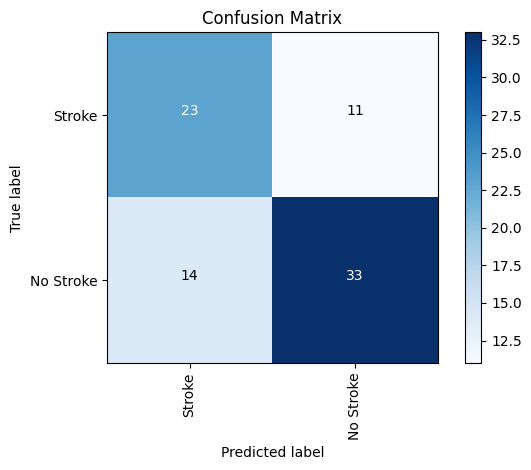

In [ ]:
draw_confusion_matrix(target_test, KNN_predicted, ['Stroke', 'No Stroke'])

Support Vector Machine

In [ ]:
from sklearn.svm import SVC

svm = SVC(probability = True, C=.25, kernel="sigmoid", gamma='auto')

svm.fit(train, target)

svm_predicted = svm.predict(test)

svm_score = svm.predict_proba(test)[:,1]

In [ ]:
C_values = []
C = 0.1
while C < 0.35:
  C_values.append(C)
  C += 0.05

for c in C_values:
  svm = SVC(probability = True, C=c, kernel="sigmoid", gamma='auto')
  svm.fit(train, target)
  svm_predicted = svm.predict(test)

  print(f"C value: {c}")
  print(f"Accuracy: {print_4_metrics(target_test,svm_predicted)}", '\n')

C value: 0.1
Accuracy:    0.703704
Precision:   0.725490
Recall:      0.787234
F1 Score:    0.755102
Accuracy: None 

C value: 0.15000000000000002
Accuracy:    0.716049
Precision:   0.740000
Recall:      0.787234
F1 Score:    0.762887
Accuracy: None 

C value: 0.2
Accuracy:    0.716049
Precision:   0.740000
Recall:      0.787234
F1 Score:    0.762887
Accuracy: None 

C value: 0.25
Accuracy:    0.716049
Precision:   0.740000
Recall:      0.787234
F1 Score:    0.762887
Accuracy: None 

C value: 0.3
Accuracy:    0.716049
Precision:   0.740000
Recall:      0.787234
F1 Score:    0.762887
Accuracy: None 



In [ ]:
print_4_metrics(target_test, svm_predicted)

Accuracy:    0.716049
Precision:   0.740000
Recall:      0.787234
F1 Score:    0.762887


Support Vector Machine Performance Results:

AUC of ROC:  0.7521902377972465


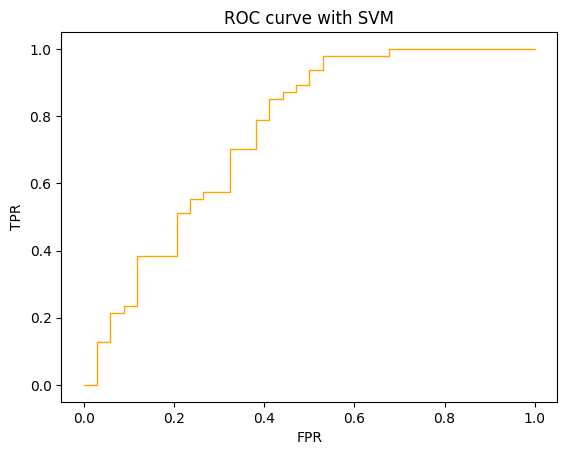

In [ ]:
fpr_svm, tpr_svm, thresholds = metrics.roc_curve(target_test,svm_score)
print("Support Vector Machine Performance Results:\n")
pyplot.figure(1)
pyplot.plot(fpr_svm, tpr_svm, color='orange', lw=1)
pyplot.title("ROC curve with SVM")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')

# report auc
# use metrics.auc(fpr, tpr)
aucroc = metrics.auc(fpr_svm, tpr_svm)
print('AUC of ROC: ', aucroc)

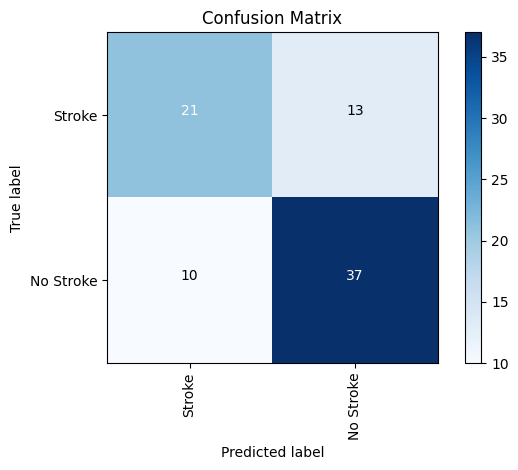

In [ ]:
draw_confusion_matrix(target_test, svm_predicted, ['Stroke', 'No Stroke'])

Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree = DecisionTreeClassifier(max_depth=5, random_state=0)

tree.fit(train, target)

tree_predicted = tree.predict(test)

tree_score = tree.predict_proba(test)[:,1]

In [ ]:
for depth in range(1,25):
  tree = DecisionTreeClassifier(max_depth=depth, random_state=0)
  tree.fit(train, target)
  tree_predicted = tree.predict(test)
  print(f"max_depth: {depth}")
  print(f"Accuracy: {metrics.accuracy_score(target_test,tree_predicted)}", '\n')

In [ ]:
print_4_metrics(target_test, tree_predicted)

Accuracy:    0.753086
Precision:   0.800000
Recall:      0.765957
F1 Score:    0.782609


Decision Tree Performance Results:

AUC of ROC:  0.7959949937421777


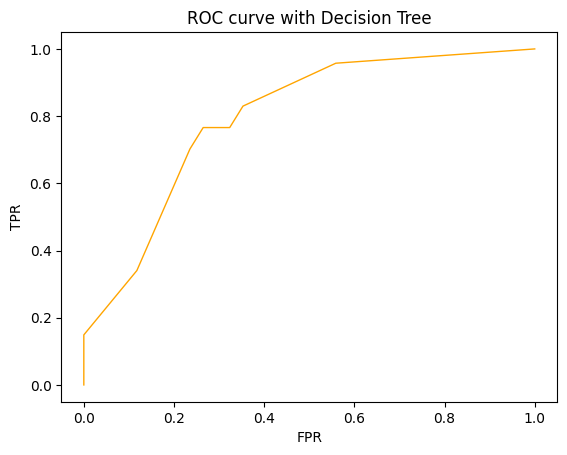

In [ ]:
fpr_tree, tpr_tree, thresholds = metrics.roc_curve(target_test,tree_score)
print("Decision Tree Performance Results:\n")
pyplot.figure(1)
pyplot.plot(fpr_tree, tpr_tree, color='orange', lw=1)
pyplot.title("ROC curve with Decision Tree")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')

# report auc
# use metrics.auc(fpr, tpr)
aucroc = metrics.auc(fpr_tree, tpr_tree)
print('AUC of ROC: ', aucroc)

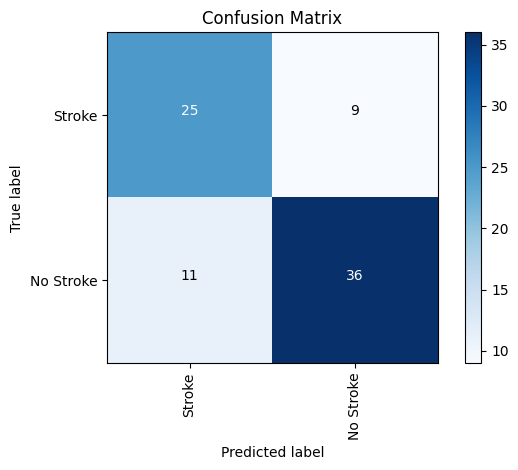

In [ ]:
draw_confusion_matrix(target_test, tree_predicted, ['Stroke', 'No Stroke'])

Decision Tree (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rf_tree = RandomForestClassifier(n_estimators=50, random_state=0) # Iterates through 50 different decision trees)

rf_tree.fit(train, target)

rf_tree_predicted = rf_tree.predict(test)

rf_tree_score = rf_tree.predict_proba(test)[:,1]
print_4_metrics(target_test, rf_tree_predicted)

Accuracy:    0.679012
Precision:   0.744186
Recall:      0.680851
F1 Score:    0.711111


Decision Tree (with Random Forest) Performance Results:

AUC of ROC:  0.7409261576971213


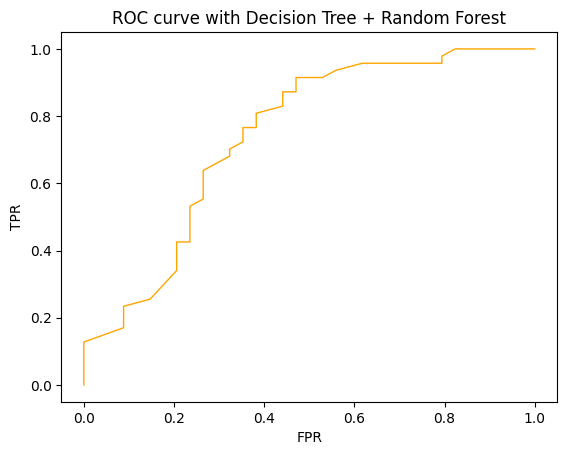

In [ ]:
fpr_rf_tree, tpr_rf_tree, thresholds = metrics.roc_curve(target_test,rf_tree_score)
print("Decision Tree (with Random Forest) Performance Results:\n")
pyplot.figure(1)
pyplot.plot(fpr_rf_tree, tpr_rf_tree, color='orange', lw=1)
pyplot.title("ROC curve with Decision Tree + Random Forest")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')

# report auc
# use metrics.auc(fpr, tpr)
aucroc = metrics.auc(fpr_rf_tree, tpr_rf_tree)
print('AUC of ROC: ', aucroc)

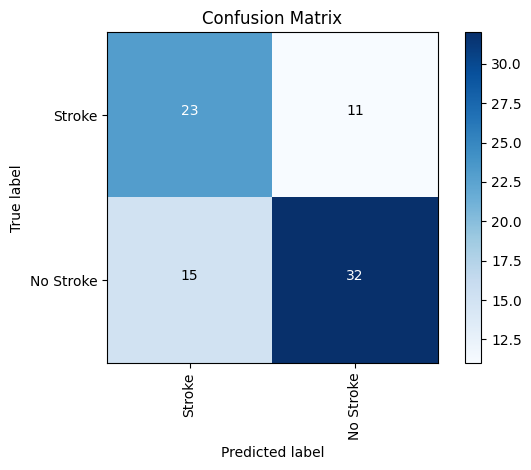

In [ ]:
draw_confusion_matrix(target_test, rf_tree_predicted, ['Stroke', 'No Stroke'])

# Visual Model of Trees

Links to Generated Images:

Decision Tree: https://drive.google.com/file/d/1oR19aWImKc_sSxXKpNyUQL4sQfjck2dB/view?usp=sharing

Random Forest Decision Tree (1/100): https://drive.google.com/file/d/1fdtxiOqqent3u3pRRCILexspCsrcX00E/view?usp=sharing

In [ ]:
# Decision Tree Model
import graphviz
from sklearn.tree import export_graphviz

data = export_graphviz(tree, out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(data, format='pdf')
graph.render("decision_tree", format='pdf', cleanup=True)

NameError: ignored

In [ ]:
# The first random forest tree models
rf_data = export_graphviz(rf_tree.estimators_[0], out_file=None, filled=True, rounded=True, special_characters=True)
rf_graph = graphviz.Source(rf_data, format='pdf')
rf_graph.render("rf_decision_tree_#1", format='pdf', cleanup=True)

'rf_decision_tree_#1.pdf'

Neural Network

Preprocessing




In [ ]:
data_nn = df
median = data_nn["bmi"].median()
data_nn["bmi"].fillna(median, inplace=True)
null_rows = data_nn[data_nn.isnull().any(axis=1)]
data_nn["stroke"].value_counts()
balanced_data_nn = data_nn[data_nn["smoking_status"] != "Unknown"].sort_values('stroke', ascending=False).head(404)
gender_map = {'Male': 0,'Female': 1,'Other': 2}
ever_married_map = {'No': 0,'Yes': 1}
work_type_map = {'children': 0,'Govt_jov': 1,'Never_worked': 2,'Private': 3,'Self-employed': 4}
residence_type_map = {'Rural': 0,'Urban': 1}
smoking_status_map = {'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3}

In [ ]:
import pandas as pd
from torch.utils.data import Dataset

class StrokeDataset(Dataset):
    def __init__(self, dataset, normalize=True, feature_transform=None, label_transform=None):
        self.feature_transform = feature_transform
        self.label_transform = label_transform

        #self.df = pd.read_csv(dataset_file_path)
        self.df = dataset
        # map strings to numbers
        self.df['gender'] = self.df['gender'].map(gender_map, na_action='ignore')
        self.df['ever_married'] = self.df['ever_married'].map(ever_married_map, na_action='ignore')
        self.df['work_type'] = self.df['work_type'].map(work_type_map, na_action='ignore')
        self.df['Residence_type'] = self.df['Residence_type'].map(residence_type_map, na_action='ignore')
        self.df['smoking_status'] = self.df['smoking_status'].map(smoking_status_map, na_action='ignore')

        # remove rows with missing data
        self.df.dropna(inplace=True)

        # normalize
        normalize_data = []

        if normalize:
            for col in self.df.columns:
                normalize_data.append(self.df[col].abs().max())
                self.df[col] = self.df[col] / self.df[col].abs().max()
        print(normalize_data)
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        # https://stackoverflow.com/a/29763653
        features = self.df.iloc[index].drop(['stroke', 'id'])
        label = self.df['stroke'].iloc[index]

        if self.feature_transform:
            features = self.feature_transform(features)
        if self.label_transform:
            label = self.label_transform(label)
        return features, label

In [ ]:
import os
import pandas as pd
import time
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split

DATASET_SPLIT = 0.8 # n% training data, 1 - n% testing data

LEARNING_RATE = 0.01
BATCH_SIZE = 128
EPOCHS = 100
NORMALIZE = True

start_time = time.time()
#model_folder_path = 'models/model_3'

# Load dataset

dataset = StrokeDataset(
    balanced_data_nn,
    normalize=NORMALIZE,
    # convert pandas object to tensor
    feature_transform=lambda feature: torch.tensor(feature, dtype=torch.float32),
    label_transform=lambda label: torch.reshape(torch.tensor(label, dtype=torch.float32), (-1,))
)

split_pos = int(len(dataset) * DATASET_SPLIT)


[72354, 1, 82.0, 1, 1, 1, 4.0, 1, 271.74, 56.6, 2, 1]


In [ ]:
train_dataset, test_dataset = random_split(dataset, [split_pos, len(dataset) - split_pos])

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [ ]:
# Build model
model = nn.Sequential(
    nn.Linear(10, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.ReLU(),
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

def train_loop():
    size = len(train_dataloader.dataset)
    for batch, (X, y) in enumerate(train_dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 30 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE
            print(f'Training MSE Loss: {loss:>7f} [{current:>4d}/{size:>4d}]')

def test_loop():
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            pred_answers = (pred > 0.5).float() # 0 or 1 only
            correct += torch.sum(torch.logical_not(torch.logical_xor(pred_answers, y))).item()

    avg_loss = test_loss / num_batches
    accuracy = correct / size
    print(f'Test Accuracy: {100 * accuracy:>0.1f}%')
    print(f'Test Average loss: {avg_loss:>8f}')

# Train and test every epoch

try:
    for epoch in range(EPOCHS):
        print()
        print(f'Epoch {epoch + 1}')
        print('-' * 20)
        train_loop()
        test_loop()

    print('Finished')

except KeyboardInterrupt:
    print('Finished early')


Epoch 1
--------------------
Training MSE Loss: 0.387268 [   0/ 277]
Test Accuracy: 47.1%
Test Average loss: 0.363091

Epoch 2
--------------------
Training MSE Loss: 0.388077 [   0/ 277]
Test Accuracy: 47.1%
Test Average loss: 0.344595

Epoch 3
--------------------
Training MSE Loss: 0.345834 [   0/ 277]
Test Accuracy: 47.1%
Test Average loss: 0.329058

Epoch 4
--------------------
Training MSE Loss: 0.313910 [   0/ 277]
Test Accuracy: 47.1%
Test Average loss: 0.314756

Epoch 5
--------------------
Training MSE Loss: 0.312097 [   0/ 277]
Test Accuracy: 47.1%
Test Average loss: 0.305326

Epoch 6
--------------------
Training MSE Loss: 0.272049 [   0/ 277]
Test Accuracy: 47.1%
Test Average loss: 0.294391

Epoch 7
--------------------
Training MSE Loss: 0.282813 [   0/ 277]
Test Accuracy: 47.1%
Test Average loss: 0.287047

Epoch 8
--------------------
Training MSE Loss: 0.269751 [   0/ 277]
Test Accuracy: 47.1%
Test Average loss: 0.281490

Epoch 9
--------------------
Training MSE Loss:

In [ ]:
predicted_labels = []
for inputs, _ in test_dataloader:
    # Forward pass
    outputs = model(inputs)
    #print(outputs)
    for output in outputs:
      if output >= 0.5:
          predicted_labels.append(1)
      else:
          predicted_labels.append(0)

predicted_df = pd.DataFrame({'Predicted Labels': predicted_labels})

In [ ]:
true_labels = []
for _, labels in test_dataloader:
    true_labels.extend(labels.flatten().tolist())
true_labels = [int(label) for label in true_labels]
true_df = pd.DataFrame({'True Labels': true_labels})

In [ ]:
print_4_metrics(true_df, predicted_df)

Accuracy:    0.628571
Precision:   0.622222
Recall:      0.756757
F1 Score:    0.682927


[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1]
[1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


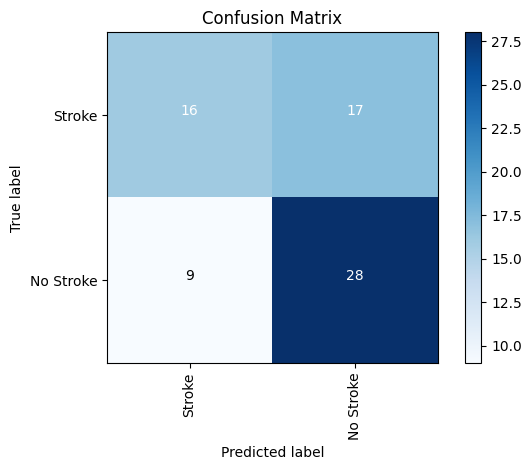

In [ ]:
print(true_labels)
print(predicted_labels)
print(type(true_df))
print(type(predicted_df))
draw_confusion_matrix(true_df, predicted_df, ['Stroke','No Stroke'])

In [ ]:
cm = confusion_matrix(true_df, predicted_df)
print(cm)

[[16 17]
 [ 9 28]]


In [ ]:
print_4_metrics(true_df, predicted_df)

Accuracy:    0.628571
Precision:   0.622222
Recall:      0.756757
F1 Score:    0.682927


In [ ]:
import torch

existing_model_path = "epoch_1000.pt"
model = torch.load(existing_model_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
print()


def predict(X):
    with torch.no_grad():
        return model(X)


# gender: Male, Female, Other
# age
# hypertension 0/1
# heart disease 0/1
# ever married: No, Yes
# work: children, Govt_jov, Never worked, Private, Self-employed
# residence: Rural, Urban
# glucose level
# bmi
# smoking: formerly smoked, never smoked, smokes, Unknown

#X = torch.tensor([0.910692, 1.841503, 2.295101, 0, 0, 0, 1, 2, 0, 1], dtype=torch.float32)
import random
random_index = random.randint(0,len(test_dataset)-1)
print("Index: "+ str(random_index))
X = test_dataset[random_index][0]
print("Input values: " + str(X))
print("Observed class:" + str(test_dataset[random_index][1][0]))
pred = predict(X)
# models/model_1/epoch_40.pt
thresh = 0.5
if pred.item()<thresh:
  print("Predicted class: 0")
  print("Prediction probability: "+str(pred.item()))

else:
  print("Predicted class: 1")
  print("Prediction probability: "+str(pred.item()))


Device: cpu

Index: 14
Input values: tensor([0.0000, 0.8780, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.3158, 0.4417,
        0.0000])
Observed class:tensor(0.)
Predicted class: 1
Prediction probability: 0.6400396823883057


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_prepared, data_target, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define the neural network model
class StrokePredictionModel(nn.Module):
    def __init__(self, input_size):
        super(StrokePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Create an instance of the model
model = StrokePredictionModel(X_train.shape[1])

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.2)

# Train the model
num_epochs = 50
batch_size = 512
best_accuracy = 0.0
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        targets = y_train[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted_labels = (outputs >= 0.5).float()
        accuracy = (predicted_labels == y_test).float().mean()
        scheduler.step(accuracy)  # Adjust learning rate based on validation accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pt')

print(best_accuracy)


tensor(0.7284)


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

StrokePredictionModel(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
with torch.no_grad():
    outputs = model(X_test)
    predicted_labels = (outputs >= 0.5).float()
    accuracy = (predicted_labels == y_test).float().mean()
    print(f'Test accuracy: {accuracy.item():.4f}')

Test accuracy: 0.7284


In [ ]:
print_4_metrics(y_test, predicted_labels)

Accuracy:    0.728395
Precision:   0.730769
Recall:      0.826087
F1 Score:    0.775510


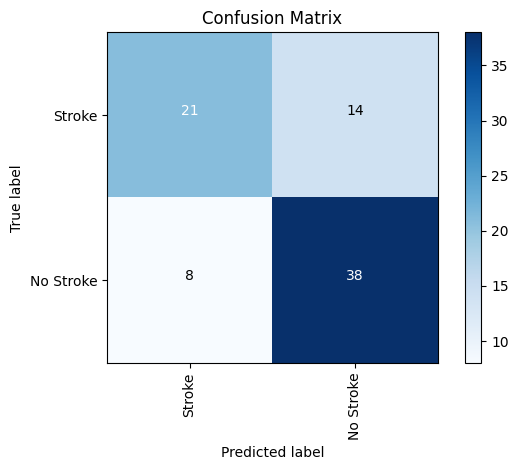

In [ ]:
draw_confusion_matrix(y_test, predicted_labels, ['Stroke', 'No Stroke'])

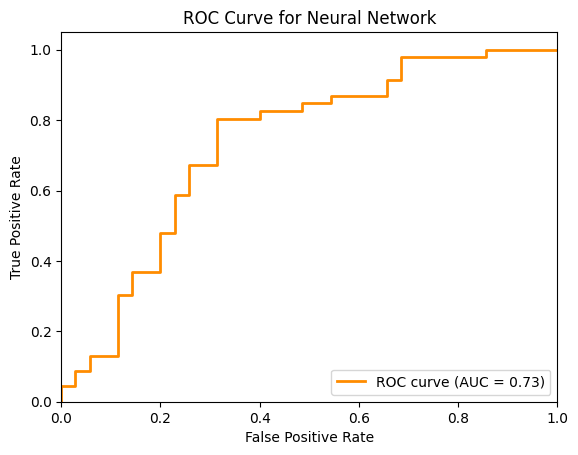

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    predicted_probabilities = outputs.numpy()

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)

# Calculate the Area Under the Curve (AUC)
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Neural Network')
plt.legend(loc='lower right')
plt.show()